In [1]:
# !pip install tab2img

## import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Activation,Dropout 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.utils import to_categorical

from tab2img.converter import Tab2Img

2022-04-05 15:06:53.754621: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


# **Read CSV files**

In [2]:
# read file
df  = pd.read_csv("dataset.csv")
df.head()

,Category of Trade,Volume/ Amount,Volume Type,Load Port,Discharge Port,Dangerous Goods,Organisation
0,7,"26,726",1,27,34,2,73
1,5,"2,600",1,44,54,2,69
2,7,"10,710",1,8,0,2,12
3,7,"21,611",1,8,40,2,12
4,7,"5,139",1,6,0,2,12


# **Seperate features and target**

In [3]:
# seperate features and target column
features = ["Category of Trade", "Volume Type", "Load Port", "Discharge Port", "Dangerous Goods"]
target = "Organisation"

# copy the feqatures and class dataframe in X and y variable
X = df[features]
y = df[target]

# **Scale features and train test split**

In [4]:
# scalling feature value between the range of 0-1
ss = StandardScaler()
X = ss.fit_transform(X)


## customize functions

In [5]:
#list of evaluation scores
evalution_scores = []

# save saller
pkl_file = open('target_encoder.pkl', 'rb')
le_target = pickle.load(pkl_file) 

# function for getting class labels via class integar using label encoder
def get_classes(y_test):
    y_test = y_test.unique()
    print(len(y_test))
    return le_target.inverse_transform(y_test)

# get unique classes in test set
def get_str_classes(y_test):
    y_test = y_test.unique()
    return [str(int) for int in y_test]

# split dataset in training and testing set 
def get_train_test_split():
    return train_test_split(X, y, test_size=0.2, random_state=42)


# split data into train, test and validation set with splitted feature and class
def get_train_test_val_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=2)
    return X_train, X_test, X_val, y_train, y_test, y_val

# split data into train, test and validation set with joined feature and class
def get_train_test_val_split_df():
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.25, random_state=2)
    return train, test, val


# compute the accuracy using true and predicted labels
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy


# compute other evaluation measures and print
def make_predictions(y_test, y_pred):
    accuracy=accuracy_score(y_test, y_pred)
    P, R, F, S = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    
    accuracy = "{:.4f}".format(accuracy)
    P = "{:.4f}".format(P)
    R = "{:.4f}".format(R)
    F = "{:.4f}".format(F)

    print("Accuracy Score :", accuracy)
    print("=======================\n")

    print("Precision Score :", P)
    print("========================\n")

    print("Recall Score :", R)
    print("=====================\n")

    print("F1 Score :", F)
    print("=================\n")

    return accuracy, P, R, F


# convert the vector input into matrix for deep leaning model
def DL_preprocessing(train, target):
    target = target.to_numpy()
    model = Tab2Img()
    images = model.fit_transform(train, target)
    
    size = (200, 200)
    reshaped_images = []
    for img in images:
        img = np.resize(img, (img.shape[0], img.shape[1], 3))
        reshaped_images.append(tf.keras.preprocessing.image.smart_resize(
            img, size, interpolation='bilinear'
        ))
    reshaped_images = np.array(reshaped_images)
    target = tf.keras.utils.to_categorical(target, 81)
    return reshaped_images, target

# plot graph of accuracy and loss using history object
def plot_graph(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# **Machine Learning Models**
## **Random Forest**

In [6]:
X_train, X_test, y_train, y_test = get_train_test_split()
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")


shape of training features : (17271, 5)

 shape of training labels : (17271,)

 shape of testing features : (4318, 5)

 shape of testing labels : (4318,)


<BarContainer object of 5 artists>

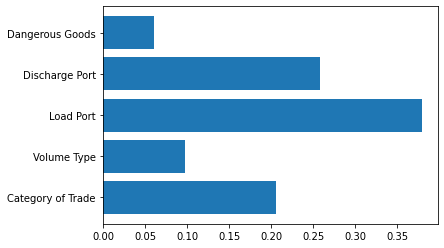

In [7]:
# model initialization
clf = RandomForestClassifier()
# model training
clf = clf.fit(X_train, y_train)
plt.barh(features, clf.feature_importances_)

In [8]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["Random Forest", Acc, P, R, F])

Accuracy Score : 0.7911

Precision Score : 0.7939

Recall Score : 0.7911

F1 Score : 0.7647



# Gradient Boosting

In [9]:
# train test split
X_train, X_test, y_train, y_test = get_train_test_split()
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")


shape of training features : (17271, 5)

 shape of training labels : (17271,)

 shape of testing features : (4318, 5)

 shape of testing labels : (4318,)


<BarContainer object of 5 artists>

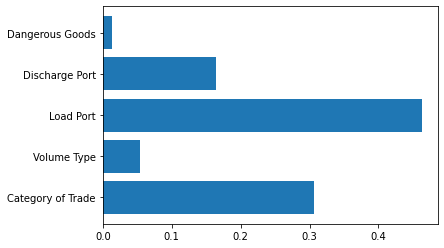

In [10]:
# model initialization
clf =  GradientBoostingClassifier()
# model training
clf = clf.fit(X_train, y_train)
plt.barh(features, clf.feature_importances_)

In [11]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["Gradient Boosting", Acc, P, R, F])

Accuracy Score : 0.0195

Precision Score : 0.0807

Recall Score : 0.0195

F1 Score : 0.0231



# **DL Models**
## **Preprocessing**

In [12]:
# convert vector data into image shape for deep learning model
train, target = DL_preprocessing(X, y)

2022-04-05 15:09:23.351882: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-05 15:09:23.573366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 15:09:23.574794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.607GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-05 15:09:23.574941: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-05 15:09:23.846887: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-05 15:09:23.960524: I tensorflow/stream_executor

# Resnet

In [13]:
# train test split
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_split(train, target)
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")
print("\n shape of validation features :", X_val.shape)
print("========================================")
print("\n shape of validation labels :", y_val.shape)
print("=====================================")


shape of training features : (15155, 200, 200, 3)

 shape of training labels : (15155, 81)

 shape of testing features : (2159, 200, 200, 3)

 shape of testing labels : (2159, 81)

 shape of validation features : (4275, 200, 200, 3)

 shape of validation labels : (4275, 81)


In [14]:
# input shape configure
input_t = tf.keras.Input(shape=(200, 200, 3))
res_model = tf.keras.applications.ResNet50(include_top=False, 
                    weights="imagenet", input_tensor=input_t)

#freeze layers
for layer in res_model.layers:
    layer.trainable = False
    
# unfreeze layers
for layer in res_model.layers[-5:]:
    layer.trainable = True

# to_res = (224, 224)
model = tf.keras.models.Sequential()  
model.add(res_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(81, activation='softmax'))

In [ ]:
# early stopping
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="default_resnet.h5",
                                          monitor="val_accuracy",
                                          mode="max",
                                          save_best_only=True,
                                          )

# model compilation
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])
 
# model training
history = model.fit(X_train, y_train, batch_size=20, epochs=10, verbose=1,
                validation_data=(X_val, y_val),
                callbacks=[check_point])

2022-04-05 15:13:17.701319: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 7274400000 exceeds 10% of free system memory.


Epoch 1/10
758/758 [==============================] - 467s 616ms/step - loss: 5.2161 - accuracy: 0.2218 - val_loss: 3.7475 - val_accuracy: 0.3443
Epoch 2/10
758/758 [==============================] - 437s 576ms/step - loss: 3.0705 - accuracy: 0.3516 - val_loss: 3.2991 - val_accuracy: 0.3579
Epoch 3/10
758/758 [==============================] - 440s 580ms/step - loss: 2.4150 - accuracy: 0.4165 - val_loss: 2.3720 - val_accuracy: 0.5130
Epoch 4/10
758/758 [==============================] - ETA: 0s - loss: 2.0509 - accuracy: 0.4625

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 81)                8128593   
Total params: 31,716,305
Trainable params: 9,183,313
Non-trainable params: 22,532,992
_________________________________________________________________
None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


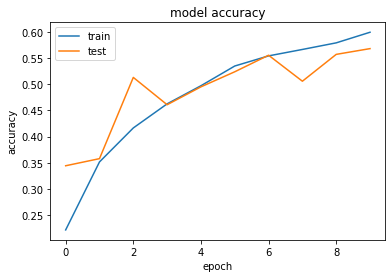

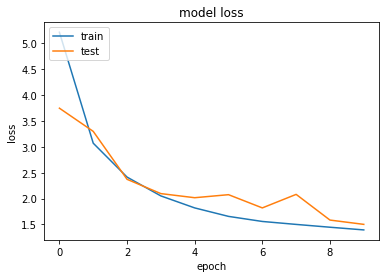

In [18]:
print(model.summary())
plot_graph(history)

In [19]:
model.load_weights('default_resnet.h5')
# make prediction using trained model
predictions = model.predict(X_test)
# calculate accuracy and other evaluation measures
y_pred = [np.argmax(prediction) for prediction in predictions]
yy_test = [list(yy).index(1) for yy in y_test]
Acc, P, R, F = make_predictions(yy_test, y_pred) 
evalution_scores.append(["ResNet", Acc, P, R, F])

Accuracy Score : 0.5994

Precision Score : 0.5702

Recall Score : 0.5994

F1 Score : 0.5429



# MobilenNet

In [20]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_split(train, target)
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")
print("\n shape of validation features :", X_val.shape)
print("========================================")
print("\n shape of validation labels :", y_val.shape)
print("=====================================")


shape of training features : (15155, 200, 200, 3)

 shape of training labels : (15155, 81)

 shape of testing features : (2159, 200, 200, 3)

 shape of testing labels : (2159, 81)

 shape of validation features : (4275, 200, 200, 3)

 shape of validation labels : (4275, 81)


In [21]:
input_t = tf.keras.Input(shape=(200, 200, 3))
mobile_model = tf.keras.applications.MobileNet(include_top=False,
                                    weights="imagenet",
                                    input_tensor=input_t)

for layer in mobile_model.layers[:143]:
    layer.trainable = False

to_res = (224, 224)
model = tf.keras.models.Sequential()  
model.add(mobile_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(81, activation='softmax'))

In [22]:
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="default_mobilenet.h5",
                                          monitor="val_accuracy",
                                          mode="max",
                                          save_best_only=True,
                                          )

model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[check_point])

2022-04-05 16:40:41.055444: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 7274400000 exceeds 10% of free system memory.


Epoch 1/10
60/60 [==============================] - 205s 3s/step - loss: 2.4164 - accuracy: 0.3982 - val_loss: 1.6946 - val_accuracy: 0.5422
Epoch 2/10
60/60 [==============================] - 114s 2s/step - loss: 1.3731 - accuracy: 0.6220 - val_loss: 1.3209 - val_accuracy: 0.6126
Epoch 3/10
60/60 [==============================] - 114s 2s/step - loss: 1.1066 - accuracy: 0.6791 - val_loss: 1.1379 - val_accuracy: 0.6760
Epoch 4/10
60/60 [==============================] - 112s 2s/step - loss: 0.9744 - accuracy: 0.7062 - val_loss: 1.0378 - val_accuracy: 0.7053
Epoch 5/10
60/60 [==============================] - 115s 2s/step - loss: 0.8938 - accuracy: 0.7223 - val_loss: 0.9611 - val_accuracy: 0.7163
Epoch 6/10
60/60 [==============================] - 112s 2s/step - loss: 0.8391 - accuracy: 0.7343 - val_loss: 0.9419 - val_accuracy: 0.6868
Epoch 7/10
60/60 [==============================] - 119s 2s/step - loss: 0.7993 - accuracy: 0.7422 - val_loss: 0.8989 - val_accuracy: 0.7338
Epoch 8/10
60

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 6, 6, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 81)                2986065   
Total params: 6,214,929
Trainable params: 2,986,065
Non-trainable params: 3,228,864
_________________________________________________________________
None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


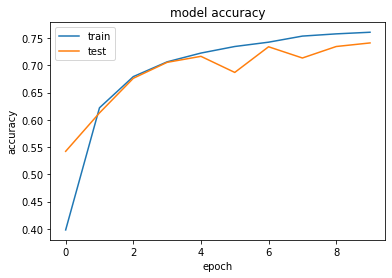

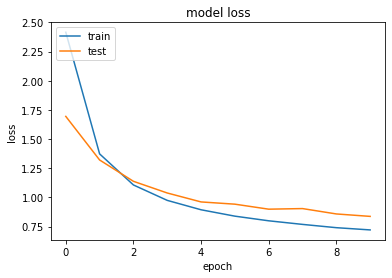

In [23]:
print(model.summary())
plot_graph(history)

In [24]:
model.load_weights('default_mobilenet.h5')
# make prediction using trained model
predictions = model.predict(X_test)
# calculate accuracy and other evaluation measures
y_pred = [np.argmax(prediction) for prediction in predictions]
yy_test = [list(yy).index(1) for yy in y_test]
Acc, P, R, F = make_predictions(yy_test, y_pred) 
evalution_scores.append(["MobileNet", Acc, P, R, F])

Accuracy Score : 0.7443

Precision Score : 0.7312

Recall Score : 0.7443

F1 Score : 0.7113



# customize model

In [25]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_split(train, target)
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")
print("\n shape of validation features :", X_val.shape)
print("========================================")
print("\n shape of validation labels :", y_val.shape)
print("=====================================")


shape of training features : (15155, 200, 200, 3)

 shape of training labels : (15155, 81)

 shape of testing features : (2159, 200, 200, 3)

 shape of testing labels : (2159, 81)

 shape of validation features : (4275, 200, 200, 3)

 shape of validation labels : (4275, 81)


In [26]:
input_t = tf.keras.Input(shape=(200, 200, 3))
mobile_model = tf.keras.applications.MobileNet(include_top=False,
                                    weights="imagenet",
                                    input_tensor=input_t)

for layer in mobile_model.layers:
    layer.trainable = False
    

for layer in mobile_model.layers[-5:]:
    layer.trainable = True

to_res = (224, 224)
model = tf.keras.models.Sequential()  
model.add(mobile_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(81, activation='softmax'))

In [27]:
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="customize-1.h5",
                                          monitor="val_accuracy",
                                          mode="max",
                                          save_best_only=True,
                                          )

model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[check_point])

2022-04-05 17:18:01.656662: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 7274400000 exceeds 10% of free system memory.


Epoch 1/10
60/60 [==============================] - 189s 3s/step - loss: 2.0202 - accuracy: 0.6707 - val_loss: 4.2001 - val_accuracy: 0.0564
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 1.3986 - accuracy: 0.7646 - val_loss: 3.9017 - val_accuracy: 0.1642
Epoch 3/10
60/60 [==============================] - 134s 2s/step - loss: 1.2444 - accuracy: 0.7799 - val_loss: 3.3809 - val_accuracy: 0.4634
Epoch 4/10
60/60 [==============================] - 133s 2s/step - loss: 1.1559 - accuracy: 0.7894 - val_loss: 2.8067 - val_accuracy: 0.6501
Epoch 5/10
60/60 [==============================] - 133s 2s/step - loss: 1.0925 - accuracy: 0.7914 - val_loss: 2.2660 - val_accuracy: 0.7240
Epoch 6/10
60/60 [==============================] - 134s 2s/step - loss: 1.0467 - accuracy: 0.7955 - val_loss: 1.7561 - val_accuracy: 0.7607
Epoch 7/10
60/60 [==============================] - 133s 2s/step - loss: 1.0018 - accuracy: 0.8000 - val_loss: 1.4471 - val_accuracy: 0.7544
Epoch 8/10
60

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 6, 6, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 36864)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 36864)             147456    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               9437440   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)              

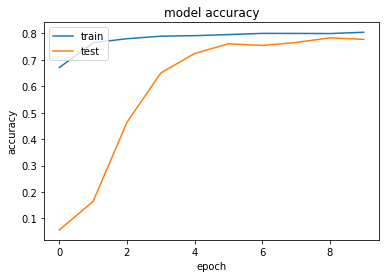

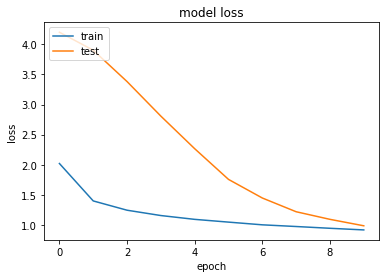

In [28]:
print(model.summary())
print("\n===================================\n")
plot_graph(history)

In [29]:
model.load_weights('customize-1.h5')
# make prediction using trained model
predictions = model.predict(X_test)
# calculate accuracy and other evaluation measures
y_pred = [np.argmax(prediction) for prediction in predictions]
yy_test = [list(yy).index(1) for yy in y_test]
Acc, P, R, F = make_predictions(yy_test, y_pred) 
evalution_scores.append(["Customize 1", Acc, P, R, F])

Accuracy Score : 0.7828

Precision Score : 0.7779

Recall Score : 0.7828

F1 Score : 0.7527



## Customize Model 2

In [55]:
# train test validation split
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_split(X, y)
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")
print("\n shape of validation features :", X_val.shape)
print("========================================")
print("\n shape of validation labels :", y_val.shape)
print("=====================================")


shape of training features : (15155, 5)

 shape of training labels : (15155,)

 shape of testing features : (2159, 5)

 shape of testing labels : (2159,)

 shape of validation features : (4275, 5)

 shape of validation labels : (4275,)


In [56]:
# deep learning model initialization
model = tf.keras.models.Sequential()  
model.add(Dense(1000,input_dim=5,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(300,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(75,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dropout(0.5))


In [57]:
RF_X_train = model.predict(X_train)
RF_X_test = model.predict(X_test)

In [58]:
# model initialization
clf = RandomForestClassifier(n_estimators=50)
# model training
clf = clf.fit(RF_X_train, y_train)

In [59]:
# model predictions
y_pred = clf.predict(RF_X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["customize 2", Acc, P, R, F])

Accuracy Score : 0.7934

Precision Score : 0.7827

Recall Score : 0.7934

F1 Score : 0.7684



In [54]:
evaluation_df = pd.DataFrame(evalution_scores, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
evaluation_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.7911,0.7939,0.7911,0.7647
1,Gradient Boosting,0.0195,0.0807,0.0195,0.0231
2,ResNet,0.5994,0.5702,0.5994,0.5429
3,MobileNet,0.7443,0.7312,0.7443,0.7113
4,Customize 1,0.7828,0.7779,0.7828,0.7527
5,customize 2,0.7957,0.8011,0.7957,0.7721
